# Финальный проект "Предсказание температуры стали"
## Описание задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.
### Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).
### Описание данных
Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы
####  Подготовка данных. 
1. Выгрузка данных. 
2. Изучение имеющихся датасетов, с помощью info, describe и пр., также построение графиков. 
#### Предобработка данных.
1. Работа с пропусками, устранение аномалий
2. Выявление только тех замеров, где известна начальная и конечная температура для дальнейшей работы.
3. Аггрегирование температур по среднему.
#### Подготовка данных для обучения
1. Формирование общей сводной таблицы.
2. Выявление признаков и целевого признака.
3. Проверка признаков на мультиколлениарность.
3. Разделение выборки на тестовую и тренировочную в пропорции 1:3 с random_state=110423
#### Обучение
1. При обучении моделей использовать gridsearch CV.
2. Обучение модели линейной регрессии со стандартизацией признаков.
3. Обучение модели CatBoost.
4. Метрика для оценки моделей - MAE.
5. Тестирование лучшей модели на тестовой выборке.
6. Проверка модели на адекватность.
7. Анализ важности факторов для лучшей модели.
#### Вывод


<font color='purpel'><b>Комментарий тимлида </b></font><br>
<font color='green'> ✔️ Хорошо, что есть цель проекта и его описание, хороший план! </font>

## Анализ данных.

### Загружаем необходимые библиотеки

In [1]:
!pip install -U scikit-learn

import warnings
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import time 
import datetime 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor


state = 100423

warnings.filterwarnings('ignore')

### Записываем все датафреймы

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Изучаем и анализируем все датафреймы

#### Данные об электродах. Рассмотрим датафрейм, изучим распределение данных, количество уникальных значение и полных дубликатов.

In [3]:
display(data_arc.head())
display(data_arc.info())
display(data_arc.describe())
display(data_arc.isna().sum())
display(data_arc.nunique())
display(data_arc.duplicated().sum()) 

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

key                      3214
Начало нагрева дугой    14875
Конец нагрева дугой     14876
Активная мощность       14869
Реактивная мощность     14866
dtype: int64

0

Видно, что всего 3214 экспериментов. Сразу можно заметить, что в реактивной мощности есть аномально низкие значение, в дальнейшем данные наблюдения можно будет удалить по ключу. Кроме того, в данных нет пропусков и значения практически не повторяются. Полные дубликаты не найдены. Далее построим гистограммs и "ящик с усами".

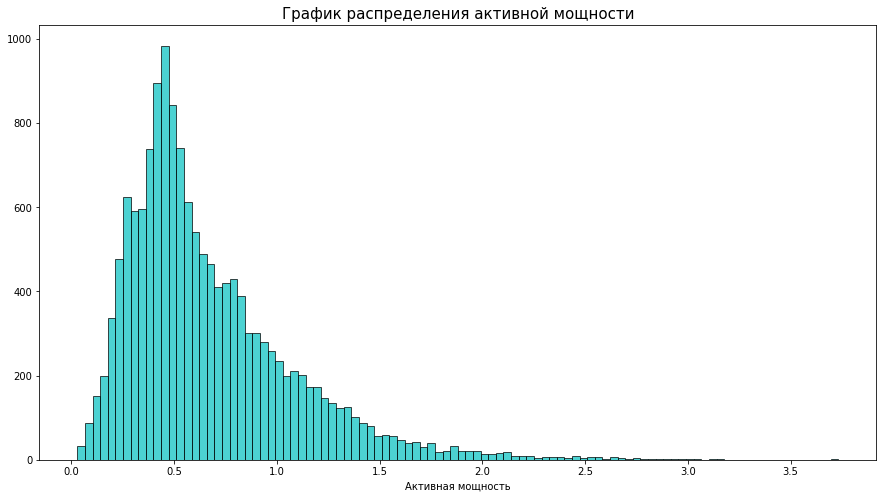

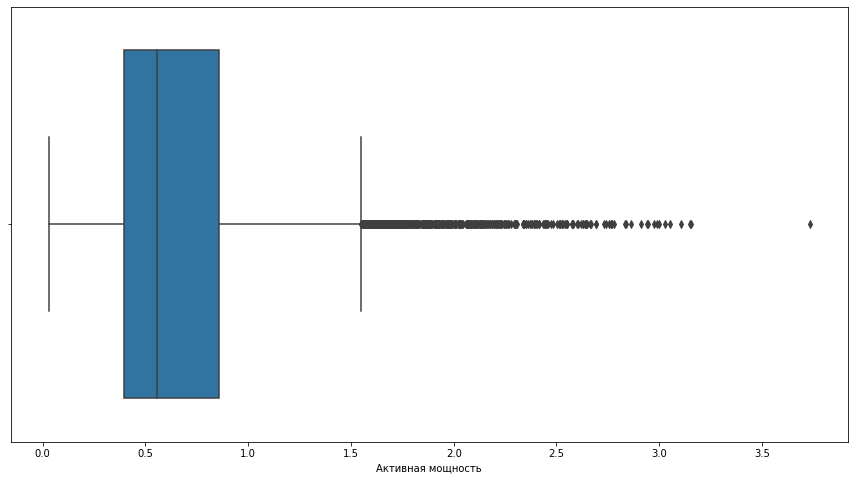

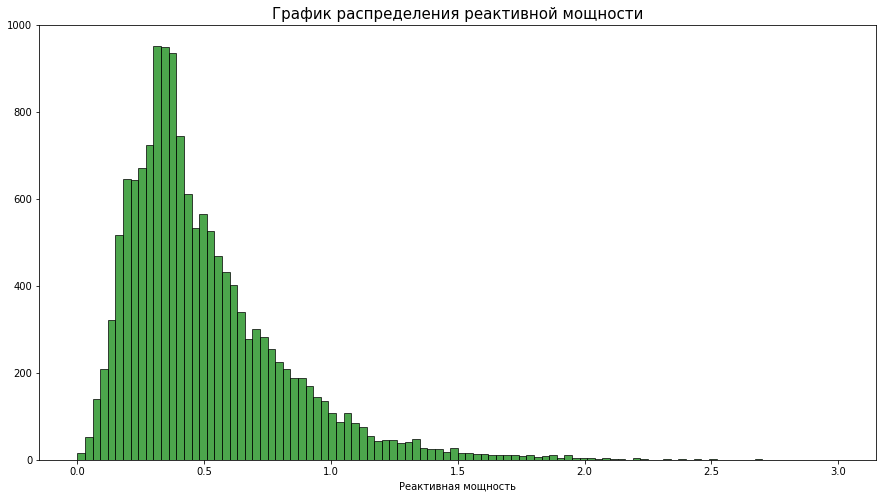

Text(0.5, 0, 'Количество ключей')

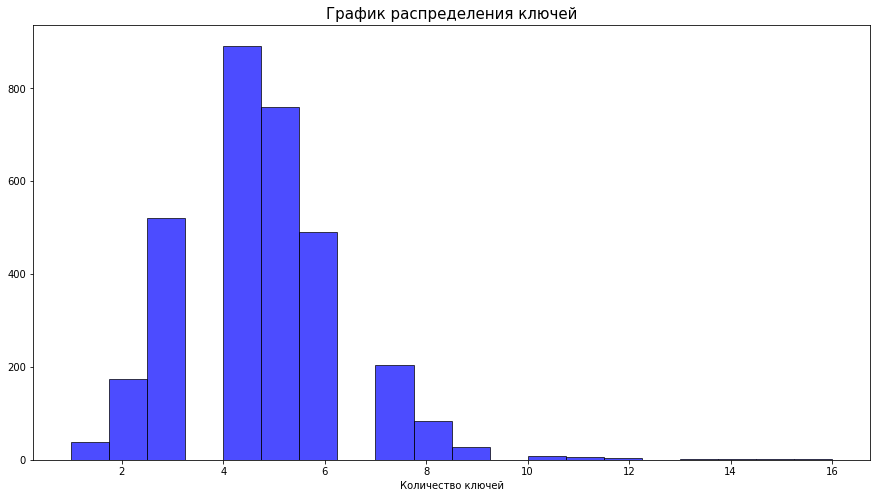

In [4]:
plt.figure(figsize=[15, 8])
plt.title('График распределения активной мощности', fontsize=15)
plt.hist(data_arc['Активная мощность'], bins=100, color = 'c', alpha = 0.7, ec='black');
plt.xlabel('Активная мощность')
plt.show()
plt.figure(figsize=[15, 8])
sns.boxplot(data_arc['Активная мощность'])
plt.show()
plt.figure(figsize=[15, 8])
plt.title('График распределения реактивной мощности', fontsize=15)
plt.hist(data_arc['Реактивная мощность'], bins=100, color = 'g', alpha = 0.7, ec='black', range=(0, 3));
plt.xlabel('Реактивная мощность')
plt.show()
plt.figure(figsize=[15, 8])
plt.title('График распределения ключей', fontsize=15)
plt.hist(data_arc['key'].value_counts(), bins=20, color = 'b', alpha = 0.7, ec='black');
plt.xlabel('Количество ключей')


Видно, что мощности распределены нормально, а количество итераций в промежутке от 1 до 16, в среднем от 2 до 8. В дальнейшем можно будет создать признак полной мощности, вместо активной и реактивной, перевести время в удобный формат и рассмотреть новый признак - время нагрева дугой.

#### Данные о подаче сыпучих материалов. Рассмотрим датафрейм, изучим распределение данных, количество уникальных значение и полных дубликатов.

In [5]:
display(data_bulk.head())
display(data_bulk.info())
display(data_bulk.describe())
display(data_bulk.isna().sum())
display(data_bulk.nunique())
display(data_bulk.duplicated().sum()) 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

key        3129
Bulk 1       47
Bulk 2       15
Bulk 3      278
Bulk 4      206
Bulk 5       55
Bulk 6      205
Bulk 7       25
Bulk 8        1
Bulk 9       10
Bulk 10      77
Bulk 11     101
Bulk 12     331
Bulk 13      14
Bulk 14     284
Bulk 15     156
dtype: int64

0

Видно, что на каждый эксперимент приходится 1 строка с примесями. Чаще всего добавляют ингридиент 12, 14 и 15. При этом 8 ингридиент добавляли только 1 раз. 2, 9 и 13 используют также крайне редко. Полных дубликатов не найдено. Рассмотрим корреляцию между примесями.

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192066,-0.038643,-0.080335,-0.101955,-0.018074,-0.063539,-0.049425,NaN,0.262741,0.288135,-0.156748,-0.030981,0.050304,-0.149840,-0.169873
Bulk 1,-0.192066,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.038643,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.080335,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.101955,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.018074,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,-0.063539,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.049425,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.262741,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN


<AxesSubplot:>

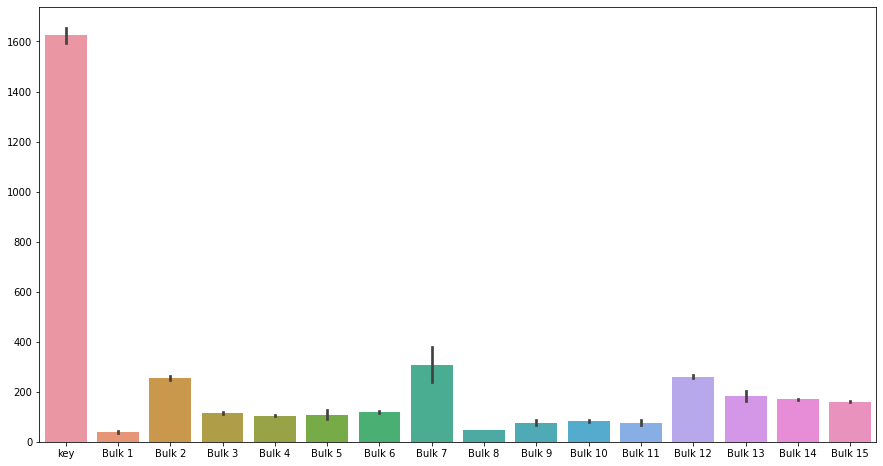

In [6]:
display(data_bulk.corr())
plt.figure(figsize=[15, 8])
sns.barplot(data=data_bulk)

Можно заметить, что есть сильная корреляция между 12 и 9 веществом - почти 0.95. Также между 4 и 9 корреляция почти 0.77, тоже высокая. Вероятно, это связано с химичесикми свойствами этих веществ, возможно при совместном применении они дают какую-либо важную химическую реакцию, либо 9 может быть базовым веществом (например, вода или песок), так как именно 9 вещество сильно коррелирует с 2 другими. В дальнейшем, пустые ячейки, которых довольно много, нужно будет заполнить нулями.

<font color='steelblue'>Сделано</font>

#### Данные о времени подачи сыпучих материалов. Рассмотрим датафрейм.

In [7]:
display(data_bulk_time.head()) 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


#### Данные о подаче газа. Рассмотрим датафрейм, изучим распределение данных, количество уникальных значение и полных дубликатов.

In [8]:
display(data_gas.head())
display(data_gas.info())
display(data_gas['Газ 1'].describe())
display(data_gas.isna().sum())
display(data_gas.nunique())
display(data_gas.duplicated().sum()) 

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

key      0
Газ 1    0
dtype: int64

key      3239
Газ 1    3239
dtype: int64

0

Text(0.5, 0, 'Газ 1')

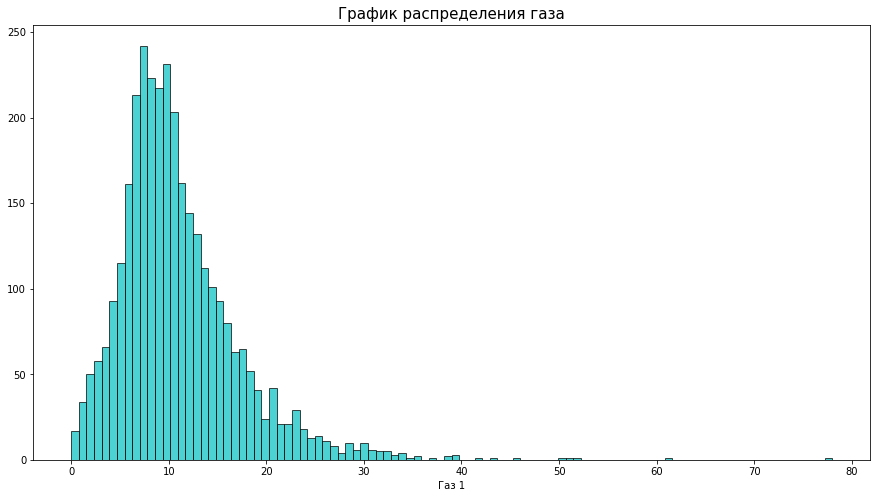

In [9]:
plt.figure(figsize=[15, 8])
plt.title('График распределения газа', fontsize=15)
plt.hist(data_gas['Газ 1'], bins=100, color = 'c', alpha = 0.7, ec='black');
plt.xlabel('Газ 1')

Данные распределены нормально, основные измерения в промежутке от 5 до 15. Не совсем понятна единица измерения. Это время подачи, либо объем.

#### Данные о температуре. Рассмотрим датафрейм, изучим распределение данных, количество уникальных значение и полных дубликатов.

In [10]:
display(data_temp.head())
display(data_temp.info())
display(data_temp['Температура'].describe())
display(data_temp.isna().sum())
display(data_temp.nunique())
display(data_temp.duplicated().sum()) 

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

key                0
Время замера       0
Температура     2901
dtype: int64

key              3216
Время замера    15907
Температура       175
dtype: int64

0

Можно увидеть, что выбросов не наблюдается. Видно, что некоторые эксперименты имеют несколько замеров, при этом около 20% замеров температуры имеют пропуски. Для нас критично, чтобы были замеры первой и последней итерации в рамках одного эксперимента. В дальнейшем нужно будет отсеять те экспиременты, оторые не будут удовлетворять этому условию. При этом известно, что эксперменты с температурой ниже 1500 градусов априори не являются успешными. Построим гистограмму с распределением температуры и количеством измерений для каждого ключа.

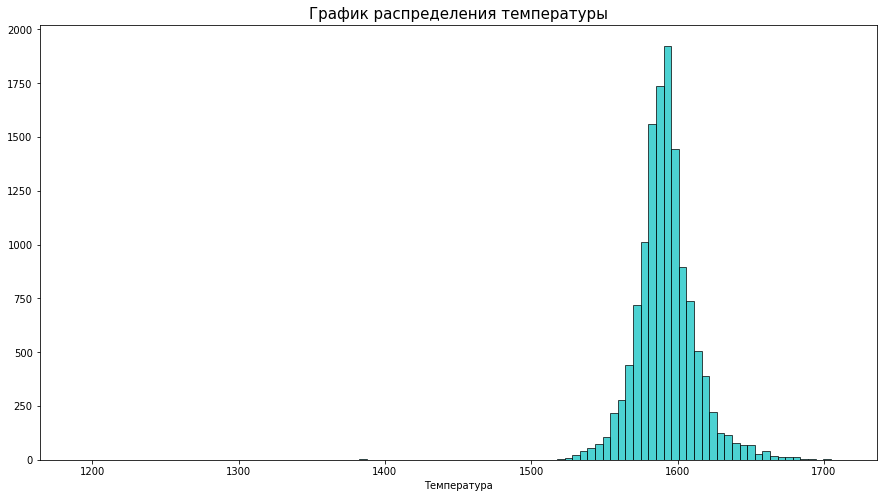

Text(0.5, 0, 'Количество измерений')

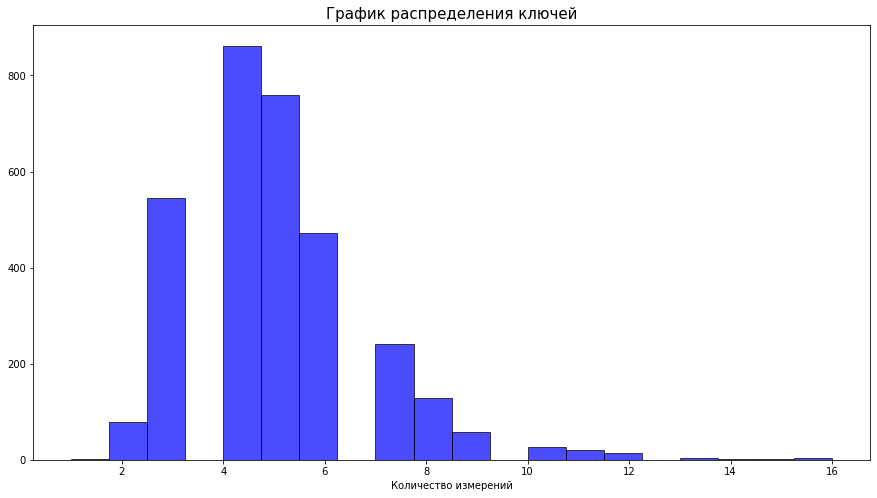

In [11]:
plt.figure(figsize=[15, 8])
plt.title('График распределения температуры', fontsize=15)
plt.hist(data_temp['Температура'], bins=100, color = 'c', alpha = 0.7, ec='black', range=(1190, 1710));
plt.xlabel('Температура')
plt.show()
plt.figure(figsize=[15, 8])
plt.title('График распределения ключей', fontsize=15)
plt.hist(data_temp['key'].value_counts(), bins=20, color = 'b', alpha = 0.7, ec='black');
plt.xlabel('Количество измерений')


Можно увидеть, что подавляющее число экспериментов имеет температуру выше 1500 градусов. 

#### Данные о проволочных материалах (объем). Рассмотрим датафрейм, изучим распределение данных, количество уникальных значение и полных дубликатов.

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

key       3081
Wire 1    2251
Wire 2     713
Wire 3      56
Wire 4      14
Wire 5       1
Wire 6      69
Wire 7      10
Wire 8      13
Wire 9      25
dtype: int64

0

               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     2

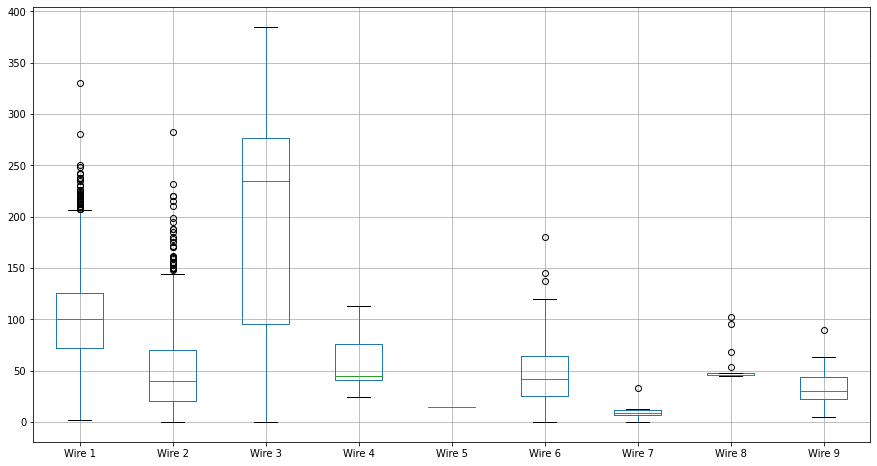

In [12]:
display(data_wire.head())
display(data_wire.info())
display(data_wire.describe())
display(data_wire.isna().sum())
display(data_wire.nunique())
display(data_wire.duplicated().sum()) 
print(data_wire.describe())
plt.figure(figsize=[15, 8])
data_wire.boxplot(column=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
plt.show()

Для каждого ключа 1 строка с проволочными материалами. При этом материал 1 используется почти повсеместно, кроме 26 экспериментов. Вероятно, это необходимый материал для процесса. 2 материал используется в 1/3 части эспериментов. Остальные маетриалы используются в единичных случаях, близко к погрешности. Пустые значения здесь нужно будет заполнить нулями.

#### Данные о проволочных материалах (время). Рассмотрим датафрейм.

In [13]:
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нужно привести время к удобномц формату.

На данном этапе не возникло глобальных вопросов, кроме тех, что были на встрече, но думаю, они точно будут позже и после ревью. 

## Подготовка данных.

Удалим все эксперименты по ключу, где реактивная мощность была ниже 0. Создадим новый признак - полная мощность. Также рассчитаем время нагрева дугой в секундах, разницей между началом и концом нагрева. Время начала и окончания нагрева удалим. Сделаем группировку, по ключу, по среднему.

In [14]:
print(len(data_arc))
a = (data_arc.loc[data_arc['Реактивная мощность'] < 0])['key']
a = int(np.array(a.tolist()))
data_arc = data_arc.loc[data_arc['key'] != a]
data_arc['Полная мощность'] = np.sqrt(data_arc['Реактивная мощность']**2 + data_arc['Активная мощность']**2)
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format="%Y/%m/%dT%H:%M:%S")
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format="%Y/%m/%dT%H:%M:%S")
data_arc['Время нагрева дугой'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
data_arc = data_arc.groupby('key').mean()
display(data_arc)


14876


,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой
key,,,,
1,0.975629,0.636648,1.165279,219.60
2,0.763150,0.499528,0.912304,202.75
3,0.505176,0.319815,0.597907,131.00
4,0.802313,0.515074,0.953741,185.25
5,0.836793,0.563161,1.008939,217.25
...,...,...,...,...
3237,0.786493,0.565692,0.968996,181.80
3238,0.702176,0.560394,0.898847,182.00
3239,0.583344,0.388952,0.701485,152.00


Теперь рассмотрим, есть ли выбросы по новым признакам.

       Активная мощность  Реактивная мощность  Полная мощность  \
count        3213.000000          3213.000000      3213.000000   
mean            0.671136             0.501593         0.839695   
std             0.207486             0.153918         0.254787   
min             0.186226             0.130062         0.228541   
25%             0.519909             0.387242         0.651907   
50%             0.646811             0.489516         0.816516   
75%             0.797278             0.599792         0.996717   
max             1.819169             1.141721         2.147979   

       Время нагрева дугой  
count          3213.000000  
mean            172.359237  
std              45.599742  
min              57.000000  
25%             140.000000  
50%             168.750000  
75%             200.400000  
max             380.000000  


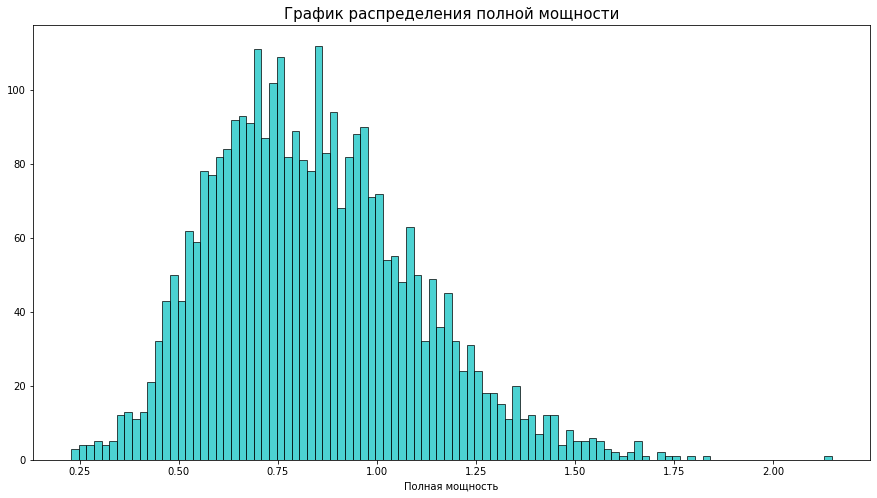

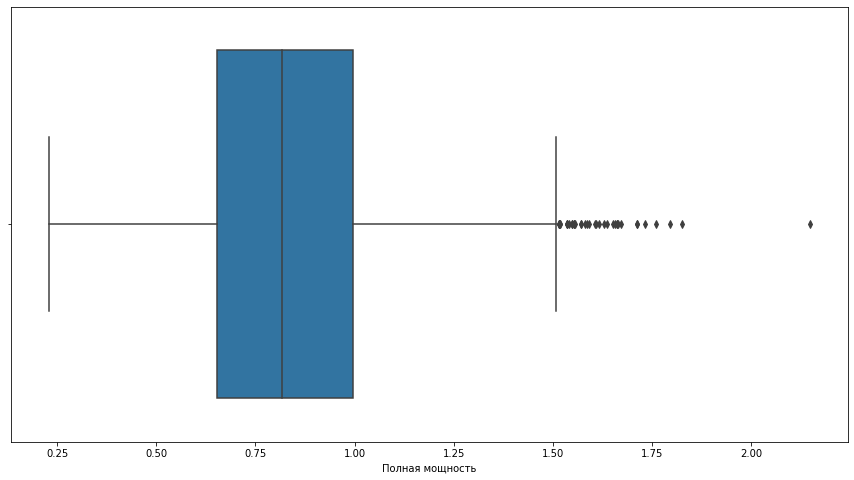

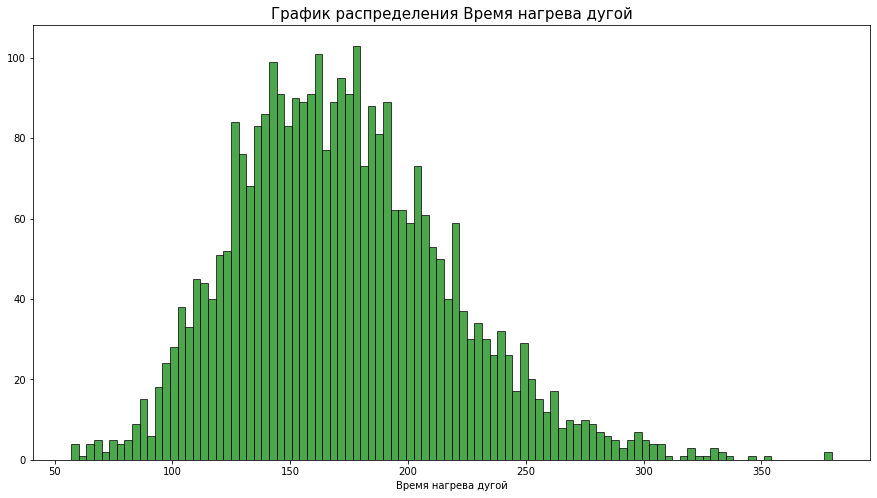

<AxesSubplot:xlabel='Время нагрева дугой'>

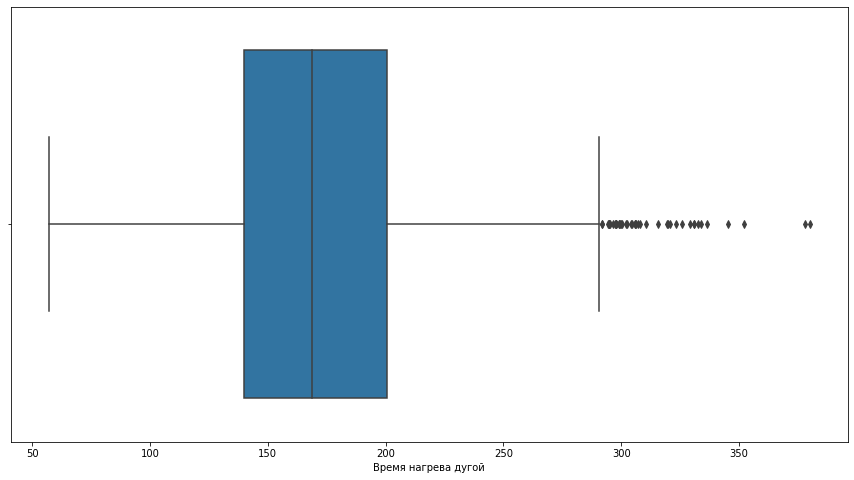

In [15]:
print(data_arc.describe())
plt.figure(figsize=[15, 8])
plt.title('График распределения полной мощности', fontsize=15)
plt.hist(data_arc['Полная мощность'], bins=100, color = 'c', alpha = 0.7, ec='black');
plt.xlabel('Полная мощность')
plt.show()
plt.figure(figsize=[15, 8])
sns.boxplot(data_arc['Полная мощность'])
plt.show()
plt.figure(figsize=[15, 8])
plt.title('График распределения Время нагрева дугой', fontsize=15)
plt.hist(data_arc['Время нагрева дугой'], bins=100, color = 'g', alpha = 0.7, ec='black');
plt.xlabel('Время нагрева дугой')
plt.show()
plt.figure(figsize=[15, 8])
sns.boxplot(data_arc['Время нагрева дугой'])

Проверим получившиеся признаки на мультиколлинеарность.

In [16]:
display(data_arc.corr())

,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой
Активная мощность,1.000000,0.929671,0.989532,0.954249
Реактивная мощность,0.929671,1.000000,0.972885,0.937251
Полная мощность,0.989532,0.972885,1.000000,0.963465
Время нагрева дугой,0.954249,0.937251,0.963465,1.000000


Видно, что корреляция очень высока, в дальнейшем, для модели линейной регресии, часть будет необходимо удалить. 

In [17]:
data_arc = data_arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1)
display(data_arc)

,Полная мощность,Время нагрева дугой
key,,
1,1.165279,219.60
2,0.912304,202.75
3,0.597907,131.00
4,0.953741,185.25
5,1.008939,217.25
...,...,...
3237,0.968996,181.80
3238,0.898847,182.00
3239,0.701485,152.00


Заполним пропуски в сыпучих материалах нулями и удалим bulk 8, который тспользовали лишь 1 раз.

In [18]:
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk.drop('Bulk 8', axis=1)
print(data_bulk.isna().sum())
display(data_bulk.head())

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [19]:
display(data_gas.head())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Оставим только значения первой и последней температуры. Удалим те эксперименты, где температура плавления была ниже 1499, либо отсуствует первый или последний замер. Непосредственное время замеров удалим.

In [20]:
data_temp = data_temp.fillna(1499)
data_temp = data_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])
data_temp.columns = ['Первое время замера', 'Последнее время замера', 'Температура в начале', 'Температура в конце']
data_temp = data_temp.loc[data_temp['Температура в начале'] > 1499]
data_temp = data_temp.loc[data_temp['Температура в конце'] > 1499]
display(data_temp.head())
print(data_temp['Первое время замера'])
print(data_temp.columns)
data_temp['Первое время замера'] = pd.to_datetime(data_temp['Первое время замера'], format="%Y/%m/%dT%H:%M:%S")
data_temp['Последнее время замера'] = pd.to_datetime(data_temp['Последнее время замера'], format="%Y/%m/%dT%H:%M:%S")
data_temp = data_temp.drop(['Первое время замера', 'Последнее время замера'], axis=1)
display(data_temp)

,Первое время замера,Последнее время замера,Температура в начале,Температура в конце
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


key
1       2019-05-03 11:16:18
2       2019-05-03 11:37:27
3       2019-05-03 12:13:17
4       2019-05-03 12:52:57
5       2019-05-03 13:23:19
               ...         
2495    2019-08-06 00:35:45
2496    2019-08-06 01:02:54
2497    2019-08-06 01:41:53
2498    2019-08-06 02:03:49
2499    2019-08-06 02:40:25
Name: Первое время замера, Length: 2473, dtype: object
Index(['Первое время замера', 'Последнее время замера', 'Температура в начале',
       'Температура в конце'],
      dtype='object')


,Температура в начале,Температура в конце
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


Определим выбросы для газа.

               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


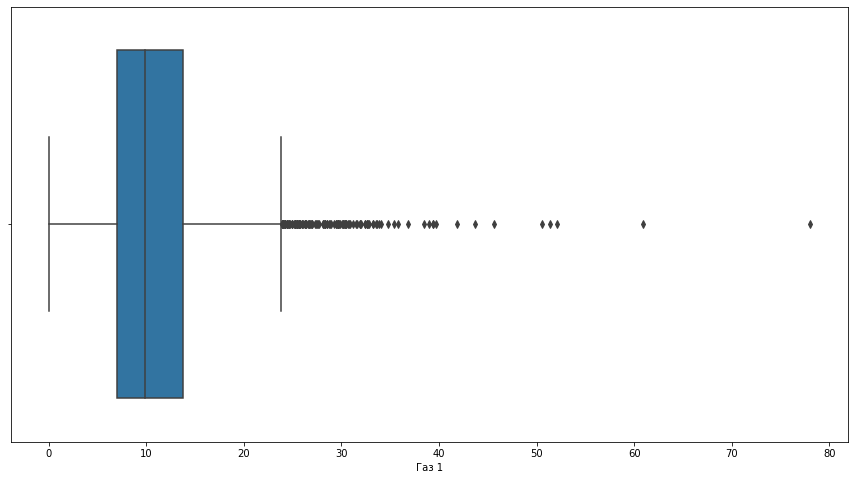

In [21]:
print(data_gas.describe())
plt.figure(figsize=[15, 8])
sns.boxplot(data_gas['Газ 1'])
plt.show()

Пропуски в сыпучих материалах заменим нулями и удалим Wire 5, который использовался лишь 1 раз.

In [22]:
data_wire = data_wire.fillna(0)
data_wire = data_wire.drop('Wire 5', axis=1)
print(data_wire.isna().sum())
display(data_wire.head())
print(data_wire.info())

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 6  3081 non-null   float64
 6   Wire 7  3081 non-null   float64
 7   Wire 8  3081 non-null   float64
 8   Wire 9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB
None


Объединим все таблицы по ключу.

In [23]:
data = data_arc.merge(data_temp, on='key')
data = data.merge(data_gas, on='key')
data = data.merge(data_bulk, on='key')
data = data.merge(data_wire, on='key')
display(data)

,key,Полная мощность,Время нагрева дугой,Температура в начале,Температура в конце,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1.165279,219.600000,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.912304,202.750000,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.597907,131.000000,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.953741,185.250000,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.008939,217.250000,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,0.996717,180.750000,1570.0,1591.0,7.125735,0.0,0.0,21.0,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2320,2496,0.842839,156.666667,1554.0,1591.0,9.412616,0.0,0.0,0.0,63.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,2497,0.961672,189.666667,1571.0,1589.0,6.271699,0.0,0.0,0.0,85.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2322,2498,0.828750,150.000000,1591.0,1594.0,14.953657,0.0,0.0,90.0,0.0,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Удалим столбец с ключами и рассмотрим данные о таблице.

In [24]:
data = data.drop('key', axis=1)
display(data)
print(data.info())
print(data.describe())
display(data.head(15))
display(data.tail(15))

,Полная мощность,Время нагрева дугой,Температура в начале,Температура в конце,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1.165279,219.600000,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.912304,202.750000,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.597907,131.000000,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.953741,185.250000,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.008939,217.250000,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,0.996717,180.750000,1570.0,1591.0,7.125735,0.0,0.0,21.0,0.0,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2320,0.842839,156.666667,1554.0,1591.0,9.412616,0.0,0.0,0.0,63.0,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,0.961672,189.666667,1571.0,1589.0,6.271699,0.0,0.0,0.0,85.0,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2322,0.828750,150.000000,1591.0,1594.0,14.953657,0.0,0.0,90.0,0.0,0.0,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Полная мощность       2324 non-null   float64
 1   Время нагрева дугой   2324 non-null   float64
 2   Температура в начале  2324 non-null   float64
 3   Температура в конце   2324 non-null   float64
 4   Газ 1                 2324 non-null   float64
 5   Bulk 1                2324 non-null   float64
 6   Bulk 2                2324 non-null   float64
 7   Bulk 3                2324 non-null   float64
 8   Bulk 4                2324 non-null   float64
 9   Bulk 5                2324 non-null   float64
 10  Bulk 6                2324 non-null   float64
 11  Bulk 7                2324 non-null   float64
 12  Bulk 9                2324 non-null   float64
 13  Bulk 10               2324 non-null   float64
 14  Bulk 11               2324 non-null   float64
 15  Bulk 12              

,Полная мощность,Время нагрева дугой,Температура в начале,Температура в конце,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1.165279,219.600000,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,...,150.0,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.912304,202.750000,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,...,149.0,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.597907,131.000000,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,0.0,...,152.0,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.953741,185.250000,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,0.0,...,153.0,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.008939,217.250000,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,0.0,...,151.0,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,1.196709,238.000000,1543.0,1596.0,11.273392,0.0,0.0,0.0,117.0,0.0,...,201.0,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
6,0.746944,168.250000,1586.0,1599.0,9.836267,0.0,0.0,0.0,117.0,0.0,...,152.0,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,1.156847,228.250000,1577.0,1598.0,15.171553,0.0,0.0,0.0,99.0,0.0,...,252.0,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.511070,125.000000,1587.0,1592.0,8.216623,0.0,0.0,0.0,117.0,0.0,...,99.0,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0
9,0.641957,137.500000,1574.0,1593.0,6.529891,0.0,0.0,0.0,0.0,0.0,...,102.0,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0


,Полная мощность,Время нагрева дугой,Температура в начале,Температура в конце,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
2309,0.497280,123.000000,1635.0,1592.0,3.361715,0.0,0.0,0.0,47.0,0.0,...,119.0,103.0,126.060479,11.038560,0.0,0.0,0.0,0.0,0.0,0.0
2310,1.084100,225.000000,1582.0,1616.0,13.050460,0.0,0.0,0.0,98.0,0.0,...,209.0,104.0,147.201599,42.103359,0.0,0.0,0.0,0.0,0.0,0.0
2311,0.877357,164.000000,1589.0,1592.0,5.976477,0.0,0.0,0.0,49.0,0.0,...,98.0,104.0,35.075039,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2312,0.677418,148.500000,1568.0,1583.0,20.135799,0.0,0.0,0.0,0.0,0.0,...,221.0,105.0,74.037598,85.413121,0.0,0.0,0.0,0.0,0.0,0.0
2313,0.570539,120.800000,1602.0,1577.0,28.306153,0.0,0.0,23.0,0.0,0.0,...,140.0,105.0,13.104000,37.066639,0.0,0.0,0.0,0.0,0.0,0.0
2314,0.715113,154.000000,1613.0,1579.0,10.772628,0.0,0.0,0.0,0.0,0.0,...,149.0,104.0,67.136162,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2315,1.043805,198.400000,1602.0,1619.0,20.019526,0.0,0.0,50.0,116.0,0.0,...,197.0,209.0,126.060486,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2316,1.073486,227.333333,1618.0,1595.0,11.375063,0.0,0.0,74.0,198.0,0.0,...,198.0,209.0,170.046235,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2317,0.705242,135.000000,1599.0,1594.0,9.421691,0.0,0.0,115.0,105.0,0.0,...,118.0,205.0,122.172958,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2318,1.018204,183.333333,1585.0,1591.0,3.983053,0.0,0.0,0.0,162.0,0.0,...,119.0,155.0,75.042236,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Разделим выборка на тренировочную и тестовую в пропорции 3:1

In [25]:
train, test = train_test_split(
    data, test_size=0.25, random_state=state)
print(train.shape)
print(test.shape)

(1743, 27)
(581, 27)


Найдем корреляцию между признаками и построим тепловую карту.

,Полная мощность,Время нагрева дугой,Температура в начале,Температура в конце,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
Полная мощность,1.000000,0.955013,-0.480653,0.193642,0.104236,0.036121,-0.029368,0.030753,-0.042583,-0.041871,...,0.344341,0.324738,-0.111375,0.006665,-0.006491,-0.030632,-0.011631,-0.030735,-0.016568,-0.030408
Время нагрева дугой,0.955013,1.000000,-0.414185,0.200839,0.117300,0.041808,-0.039337,0.010526,-0.038388,-0.039065,...,0.342257,0.275743,-0.105581,0.002205,-0.010188,-0.043728,-0.030153,-0.035543,-0.031455,-0.018160
Температура в начале,-0.480653,-0.414185,1.000000,0.326594,0.040816,0.087035,0.150207,-0.122972,0.175621,0.085322,...,-0.179120,-0.055700,0.256798,-0.120276,0.000973,0.073983,0.102521,0.058451,-0.031605,0.023082
Температура в конце,0.193642,0.200839,0.326594,1.000000,0.086800,-0.072203,-0.070065,-0.055111,0.190324,-0.020015,...,0.102158,0.260341,0.315263,-0.205050,-0.045937,-0.165364,-0.080707,-0.155020,-0.014486,-0.024167
Газ 1,0.104236,0.117300,0.040816,0.086800,1.000000,0.257548,0.210545,0.057965,0.024824,0.078173,...,0.265828,0.047550,0.120310,0.104360,0.091846,0.131154,0.123163,0.085423,0.136605,-0.008458
Bulk 1,0.036121,0.041808,0.087035,-0.072203,0.257548,1.000000,0.235812,-0.014811,0.054015,0.060537,...,0.222352,-0.003410,0.021113,0.006792,0.029909,0.147315,0.186947,0.089134,-0.022596,0.022514
Bulk 2,-0.029368,-0.039337,0.150207,-0.070065,0.210545,0.235812,1.000000,-0.052619,0.042660,0.351896,...,-0.154571,-0.115198,-0.188265,-0.042679,0.255536,0.676868,0.711804,0.444210,-0.006499,-0.007285
Bulk 3,0.030753,0.010526,-0.122972,-0.055111,0.057965,-0.014811,-0.052619,1.000000,-0.303744,-0.003855,...,0.003793,-0.016351,0.029538,0.112070,0.009057,-0.044979,0.003373,-0.022359,0.009530,0.012170
Bulk 4,-0.042583,-0.038388,0.175621,0.190324,0.024824,0.054015,0.042660,-0.303744,1.000000,0.039059,...,-0.088432,0.112790,0.296017,-0.261523,-0.039374,0.035570,0.002152,0.038817,0.013004,-0.055464
Bulk 5,-0.041871,-0.039065,0.085322,-0.020015,0.078173,0.060537,0.351896,-0.003855,0.039059,1.000000,...,-0.066653,-0.076728,-0.018286,-0.019577,0.080342,0.249186,0.258476,0.174058,-0.009885,-0.011081


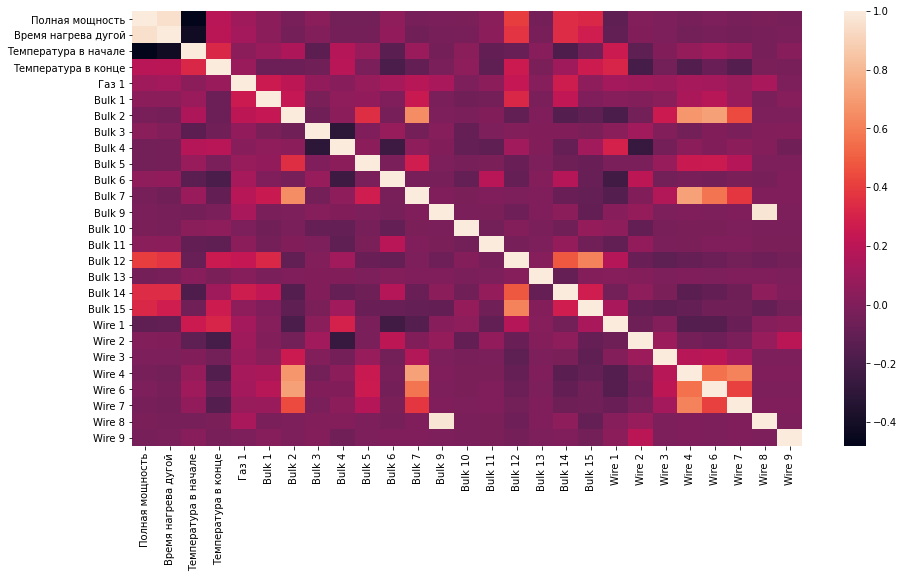

In [26]:
plt.figure(figsize=[15, 8])
sns.heatmap(train.corr())
display(train.corr())

Выделим признаки с корреляцией выше 0.9. Для некоторых моделей в дальнейшем их нужно будет удалить из датафрейма.

In [27]:
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['Время нагрева дугой', 'Wire 8']


Удалим выбросы ииз тренировочной таблицы.

In [28]:
train = train.loc[train['Полная мощность'] < 1.5]
train = train.loc[train['Время нагрева дугой'] < 300]
train = train.loc[train['Wire 1'] < 220]
train = train.loc[train['Wire 2'] < 150]
train = train.loc[train['Wire 6'] < 130]
train = train.loc[train['Wire 7'] < 30]
train = train.loc[train['Wire 8'] < 50]
train = train.loc[train['Wire 9'] < 75]
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 497 to 1879
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Полная мощность       1689 non-null   float64
 1   Время нагрева дугой   1689 non-null   float64
 2   Температура в начале  1689 non-null   float64
 3   Температура в конце   1689 non-null   float64
 4   Газ 1                 1689 non-null   float64
 5   Bulk 1                1689 non-null   float64
 6   Bulk 2                1689 non-null   float64
 7   Bulk 3                1689 non-null   float64
 8   Bulk 4                1689 non-null   float64
 9   Bulk 5                1689 non-null   float64
 10  Bulk 6                1689 non-null   float64
 11  Bulk 7                1689 non-null   float64
 12  Bulk 9                1689 non-null   float64
 13  Bulk 10               1689 non-null   float64
 14  Bulk 11               1689 non-null   float64
 15  Bulk 12            

Определим целевые признаки и остальные, проверим размерность получившихся датасетов.

In [29]:
features_train = train.drop('Температура в конце', axis=1)
target_train = train['Температура в конце']
features_test = test.drop('Температура в конце', axis=1)
target_test = test['Температура в конце']
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1689, 26)
(1689,)
(581, 26)
(581,)


Для линейной модели стандартизируем признаки и удалим те, где высокая корреляция.

In [30]:
scaler=StandardScaler()
features_train_scal = scaler.fit_transform(features_train)
features_test_scal = scaler.fit_transform(features_test)

cols = features_train.columns
scaler=StandardScaler()
features_train_scal = pd.DataFrame(scaler.fit_transform(features_train), columns=cols)
features_test_scal = pd.DataFrame(scaler.fit_transform(features_test), columns=cols)
features_train_scal.index = target_train.index
features_test_scal.index = target_test.index

features_train_scal = features_train_scal.drop(to_drop, axis=1)
features_test_scal = features_test_scal.drop(to_drop, axis=1)

display(features_train_scal.head())
display(features_test_scal.head())
print(features_train_scal.shape)
print(features_test_scal.shape)
print(target_train.shape)
print(target_test.shape)

,Полная мощность,Температура в начале,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
497,1.670547,-0.969336,-0.482934,-0.29677,-0.084161,-0.630853,-0.634912,-0.125391,3.183748,-0.068788,...,-0.075307,0.624121,1.224399,-1.154913,-0.537980,-0.115673,-0.071939,-0.120916,-0.035759,-0.079537
1267,0.674060,-1.139140,-0.210090,-0.29677,-0.084161,0.514307,-0.634912,-0.125391,4.961029,-0.068788,...,-0.075307,2.767615,1.083147,-0.397019,-0.537980,-0.115673,-0.071939,-0.120916,-0.035759,-0.079537
319,0.439264,-0.714630,1.331945,-0.29677,-0.084161,-0.630853,-0.634912,-0.125391,0.290941,-0.068788,...,-0.075307,0.611731,-0.046868,-1.058637,3.279932,-0.115673,-0.071939,-0.120916,-0.035759,-0.079537
427,-0.730699,0.219293,-1.177001,-0.29677,-0.084161,-0.630853,0.949595,-0.125391,-0.389720,-0.068788,...,-0.075307,-0.565332,0.412201,1.666198,-0.537980,-0.115673,-0.071939,-0.120916,-0.035759,-0.079537
1019,-0.398414,1.195666,-0.619854,-0.29677,-0.084161,0.999316,-0.634912,-0.125391,1.482097,-0.068788,...,-0.075307,-0.292749,-0.164578,0.107870,0.988559,-0.115673,-0.071939,-0.120916,-0.035759,-0.079537


,Полная мощность,Температура в начале,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
1779,-0.750169,1.349610,1.035750,-0.24065,-0.041523,-0.612317,1.836625,-0.101749,-0.441908,-0.041523,...,-0.079802,-0.722330,-0.241293,0.744740,-0.548692,-0.12207,-0.041523,-0.114813,-0.041523,-0.102766
936,0.883799,-1.094774,-0.531293,-0.24065,-0.041523,2.244139,-0.642915,-0.101749,-0.441908,-0.041523,...,-0.079802,-0.609767,-0.265441,0.021913,-0.548692,-0.12207,-0.041523,-0.114813,-0.041523,-0.102766
578,-0.750427,2.178955,2.879833,-0.24065,-0.041523,-0.612317,-0.642915,-0.101749,2.435680,-0.041523,...,-0.079802,-1.973034,-1.509065,-0.022719,5.659223,-0.12207,-0.041523,-0.114813,-0.041523,-0.102766
7,1.222755,-0.396379,0.677897,-0.24065,-0.041523,-0.612317,1.026979,-0.101749,-0.441908,-0.041523,...,-0.079802,1.178740,0.338260,1.259646,-0.548692,-0.12207,-0.041523,-0.114813,-0.041523,-0.102766
1578,0.918742,-0.789226,-0.439834,-0.24065,-0.041523,-0.612317,-0.642915,-0.101749,1.978651,-0.041523,...,-0.079802,-0.359626,-0.217145,0.673981,2.091742,-0.12207,-0.041523,-0.114813,-0.041523,-0.102766


(1689, 24)
(581, 24)
(1689,)
(581,)


## Обучение

Обучим на тренировочных данных модель линейной регрессии и посчитаем MAE на трениоовочных данных.

In [31]:
%%time
model_lr = LinearRegression()
mae_lr = cross_val_score(model_lr, features_train_scal, target_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
mae_lr = mae_lr.mean()  
mae_lr = mae_lr * (-1)
print(mae_lr)

6.984457013748894
CPU times: user 140 ms, sys: 524 ms, total: 664 ms
Wall time: 664 ms


MAE на тренировочной выборке получилось около 6.98

Воспользуемся gridsearchCV для кросс-валидации и подбора лучших параметров для обучения модели catboost. Рассчитаем МАЕ и определим лучшие параметры.

In [32]:
%%time
model_cb = CatBoostRegressor()
params = {
        'n_estimators' : [10, 200, 400],
        'random_state' : [state],
        'max_depth' : [3, 10, 20],
        'learning_rate' : [0.03, 0.3, 0.7] 
    }
grid_cat = GridSearchCV(model_cb, params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)
grid_cat.fit(features_train, target_train)
mae_cat = (grid_cat.best_score_)*(-1)
print('Best params for CatBoost: ', grid_cat.best_params_)
print('Best MAE for CatBoost', mae_cat)

0:	learn: 11.1479789	total: 55.1ms	remaining: 496ms
1:	learn: 11.0853690	total: 56.3ms	remaining: 225ms
2:	learn: 11.0339095	total: 57.4ms	remaining: 134ms
3:	learn: 10.9781285	total: 58.8ms	remaining: 88.2ms
4:	learn: 10.9380504	total: 60.2ms	remaining: 60.2ms
5:	learn: 10.8829113	total: 61.6ms	remaining: 41.1ms
6:	learn: 10.8367037	total: 63.1ms	remaining: 27ms
7:	learn: 10.7916257	total: 64.4ms	remaining: 16.1ms
8:	learn: 10.7436490	total: 65.7ms	remaining: 7.3ms
9:	learn: 10.7032897	total: 67.3ms	remaining: 0us
0:	learn: 10.8193117	total: 1.26ms	remaining: 11.3ms
1:	learn: 10.7677102	total: 2.69ms	remaining: 10.8ms
2:	learn: 10.7154893	total: 4.09ms	remaining: 9.54ms
3:	learn: 10.6735701	total: 5.46ms	remaining: 8.19ms
4:	learn: 10.6387696	total: 6.77ms	remaining: 6.77ms
5:	learn: 10.5949676	total: 8.08ms	remaining: 5.39ms
6:	learn: 10.5597538	total: 9.46ms	remaining: 4.05ms
7:	learn: 10.5167292	total: 10.8ms	remaining: 2.69ms
8:	learn: 10.4788908	total: 12ms	remaining: 1.33ms
9:	l

MAE на тренировочной выборке получилось около 6.43

Воспользуемся gridsearchCV для кросс-валидации и подбора лучших параметров для обучения модели LGMB. Рассчитаем МАЕ и определим лучшие параметры.

In [ ]:
%%time
model_lgbm = LGBMRegressor()
params = {'num_leaves':[30, 100],
          'boosting_type' : ['gbdt'],
          'random_state' : [state],
          'n_estimators': [50, 100], 
          'learning_rate': [0.03, 0.1],
          'max_depth': [3, 7],
          'verbose' : [100]
                  }

grid_lgbm = GridSearchCV(model_lgbm, params, cv=5, scoring='neg_mean_absolute_error') 
grid_lgbm.fit(features_train, target_train)
mae_lgbm = (grid_lgbm.best_score_)*(-1)
print('Best params for LGBM: ', grid_lgbm.best_params_)
print('Best MAE for LGBM', mae_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.873263
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.504811
[LightGBM] [Debug] init for col-wise cost 0.391972 seconds, init for row-wise cost 0.406361 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.498184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 1351, number of used features: 18
[LightGBM] [Info] Start training from score 1592.935603
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [De

MAE для LGBM около 6.56. Лучший результат показала модель Catboost. Получим метрику для тестовой выборки.

In [ ]:
model_cb = CatBoostRegressor(random_state=state, max_depth=3,n_estimators=400,learning_rate=0.03)
model_cb.fit(features_train, target_train)
predict_cb = model_cb.predict(features_test)
mae_cb=mean_absolute_error(target_test, predict_cb)
print(mae_cb)

Значение на тестовой выьорке 6.64. Результат ниже 6.8, значит он удовлетворяем условию. Далее проверим важность каждого признака для модели.

In [ ]:
model_cb.feature_importances_

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model_cb.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model_cb.feature_importances_[sorted_idx])
plt.xlabel("model_cb feature importance")

Видно, что наибольшее значение имела температура в начале, далее полная мощность, Wire1 и время нагрева дугой. Далее рассмотрим константную модель, чтобы проверить нашу модель на адекватность.

In [ ]:
model = DummyRegressor(strategy="mean")
model.fit(features_train, target_train)
predict = model.predict(features_test)
mae_gd = mean_absolute_error(target_test, predict)
print(mae_gd)

Констатная модель дает около 8.03, что значительно хуже, чем наша модель. Таким образом, модель прошла проверк на адекватность.

## Итоги

1. Были изучены и проанализированы входные данные. Мы внесли изменения в датасет, рассмотрели распределение данных, убрали лишние данные, выбросы, применили кодирование данных.
2. Мы обучили 3 разные модели с перебором гиперпараметров и кросс-валидацией, вычислили для каждой из них метрику качества МАЕ и время обучения.
3. Лучшей моделью быа выбрана CatBoostRegressor.
4. Требование к занчению метрики менее 6.8 выполнено для всех моделей из данного исследования, кроме линейной регрессии.

## Отчет

### Соответствие плану.
#### Продублирую план:

#####  Подготовка данных. 
1. Выгрузка данных. 
2. Изучение имеющихся датасетов, с помощью info, describe и пр., также построение графиков. 
##### Предобработка данных.
1. Работа с пропусками, устранение аномалий
2. Выявление только тех замеров, где известна начальная и конечная температура для дальнейшей работы.
3. Аггрегирование температур по среднему.
##### Подготовка данных для обучения
1. Формирование общей сводной таблицы.
2. Выявление признаков и целевого признака.
3. Проверка признаков на мультиколлениарность.
3. Разделение выборки на тестовую и тренировочную в пропорции 1:3 с random_state=100423
##### Обучение
1. При обучении моделей использовать gridsearch CV.
2. Обучение модели линейной регрессии со стандартизацией признаков.
3. Обучение модели CatBoost.
4. Метрика для оценки моделей - MAE.
5. Тестирование лучшей модели на тестовой выборке.
6. Проверка модели на адекватность.
7. Анализ важности факторов для лучшей модели.
##### Вывод


1. Этап подготовки данных выполнен в полном объеме.
2. Предобработка данных также выполнена в полном объеме. Также, помимо плана, было сформировано 2 новых признака - время воздействия дугой и полная мощность. 
3. Подготовка данных для обучения также была выполнена в полном объеме. Были убраны: все замеры с температурой ниже 1500 градусов, вся отрицательная энергия, выбросы по всем проволочным и сыпучим веществам. Пропуски в таблицах по веществам заполнялись нулями. В результате подготовки данных, из 3239 экспериментов в итоговой таблице осталось 2270 удовлетворящих всем необходимым условиям. Также из таблицы были убраны столбцы, в которых указано время всех замеров, активная и реактивная энергия, Wire 5 и Bulk 8. В связи с высокой корреляцией признаков, либо с редким использованием тех или иных материалов. Кроме того, для модели линейной регрессии была выполнена стандартизация значений признаков. Таким образом, после всех преобразований, размер тренировочной выборки стал равен 1689 строк на 26 столбцов, а размер тестовой выборки - 581 строка на 26 столбцов. Общая доля замеров, которая не вошла в итоговый датасет составила около 30%.
4. К этапу обучения было добавлено обучение модели LGBM. Все модели обучались с испольщованием кросс-валидации, и все, кроме линейной регрессии, с подбором параметров через gridsearch. Наилучшие значения MAE на тестовоцй выборке показала модель catboost (с параметрами max_depth=3, n_estimators=400, learning_rate=0.03), около 6.4, далее, именно с помощью этой модели была посчитана метрика качества на тестовой выборке, которая составила около 6.6, что соответсвует поставленному условию. Кроме того, была построена диаграмма с анализом важности признаков для лучшей модели - catboost. Самыми важными признаками, по убыванию, стали: температура в начале, далее полная мощность, Wire 1 и время нагрева дугой. В рамках проверки модели на адекватность, была использована константная модель, которая показала значение метрики 8.03, что значительно хуже той, что дала модель catboost. Следовательно, модель можно считать адекватной. 
5. Поставленная задача корректно выполнена. Грамотный анализ, предобработка и подготовка данных, а так же машинное обучение помогли достичь поставленной задачи.

<font color='green'>
    Чтобы ты всегда мог делать качественную визуализацию затрачивая на это минимум, энергии рекомендую тебе держать под рукой галерею примеров библиотеки seaborn(https://seaborn.pydata.org/examples/index.html), https://habr.com/ru/company/skillfactory/blog/664756/ и  plotly(https://plotly.com/python/). С её помощью можно строить интерактивные графики любой сложности. \
    Для работы с оптимизацией параметров советую ознакомится с материалом, здесь ты найдёшь основные алгоритмы поиска параметров, метод их работы и особенности https://academy.yandex.ru/handbook/ml/article/podbor-giperparametrov. \
    Для получения хорошего качества моделей в классическом ML необходимо уделять внимание предобработке данных https://alexanderdyakonov.wordpress.com/2017/04/19/%D0%BF%D0%BE%D0%B8%D1%81%D0%BA-%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9-anomaly-detection/ , а также конструированию признаков https://habr.com/ru/company/ruvds/blog/680498/.
    Для интерпритации важности признаковом можно использовать библиотеки lime и shape https://habr.com/ru/company/ods/blog/599573/, https://towardsdatascience.com/lime-vs-shap-which-is-better-for-explaining-machine-learning-models-d68d8290bb16. \
    Если захочешь заняться нейронными сетями и DL, можно начать с обучений от Samsung на stepic.org https://stepik.org/course/54098/info . 

Удачи!🍀)

</font>.</font>